## Ablation Study of Convolutional Downsampling in the Embedder Net

In this notebook, we conduct an ablation study on the convolutional layers that constitute the first sequential block of the `Embedder` class. The objective is to analyze how different downsampling strategies affect foreground classification performance. Specifically, we compare two architectural components used for spatial downsampling:

- **Strided Convolution**  
  A sequence of `nn.Conv2d(out_c, out_c, kernel_size=3, stride=2, padding=1)` followed by `nn.ReLU()`

- **Max Pooling**  
  A `nn.MaxPool2d(kernel_size=2)` operation

These alternatives are selected via the `downsample_mode` argument in the `Embedder` class, as implemented in `src/models.py`. The comparison is performed both:
quantitatively, using metrics such as classification accuracy, validation loss, number of model parameters, and training time, and qualitatively, through theoretical analysis of the representational and optimization implications of each approach.

In the first section of this notebook, we define the experiment configuration, including path setup and initialization of the relevant data loaders.

In [ ]:
%load_ext autoreload
%autoreload 2

import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import json 
import torch
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

import pandas as pd

from handsoncv.datasets import CILPFusionDataset
from handsoncv.models import IntermediateFusionNet
from handsoncv.training import train_fusion_cilp_model
from handsoncv.utils import set_seed, seed_worker
from handsoncv.visualization import plot_table_task4_metrics
from torchvision import transforms
from torch.utils.data import DataLoader

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")
RESULTS_DIR = os.path.join(ROOT_PATH, "results", "tables")
os.makedirs(RESULTS_DIR, exist_ok=True) # Ensures folder exists 

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
IMG_SIZE = 64
BATCH_SIZE = 32

Using GPU: NVIDIA GeForce RTX 3090
cuda


In the following cell, we set a fixed random seed to ensure reproducible data shuffling in the DataLoader multiprocessing pipeline. We then use a custom data-loading function, implemented in `src/datasets.py` which takes a predefined list of samples to construct the training and validation splits. These sample lists were generated and saved earlier using the notebook `01_dataset_exploration.ipynb`.

In [2]:
# Load split dictionary previouslu created with 01_dataset_exploration.ipynb
mapping_file = "subset_splits.json"
with open(f"{ROOT_PATH}/{mapping_file}", "r") as f:
    splits = json.load(f)
    
SEED = splits["seed"] # From .json file created through notebook 01_dataset_exploration.ipynb 
set_seed(SEED)

# Instantiate Dataset and relative Transformation
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

train_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["train"], transform=img_transforms)
val_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["val"], transform=img_transforms)

# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

print(f"Ready to train with {len(train_ds)} training pairs and {len(val_ds)} validation pairs.")

Seeds set to 42 for reproducibility.
Ready to train with 4799 training pairs and 1200 validation pairs.


Finally, the last configuration cell ensures a balanced distribution of classes within the training and validation batches. This is particularly important because **the datasets provided in the NVIDIA notebooks produced batches containing only a single class**, leading to unreliable accuracy estimates. These three configuration cells are shared across the experimental notebooks `02_*`, `03_*`, and `04_*`.

In [3]:
assert set(train_ds.sample_ids).isdisjoint(set(val_ds.sample_ids)), "DATA LEAKAGE DETECTED!"

leaked_ids = set(train_ds.sample_ids).intersection(set(val_ds.sample_ids))
print(f"Found {len(leaked_ids)} overlapping IDs.")
print(f"Example leaked IDs: {list(leaked_ids)[:10]}")

train_labels = next(iter(train_loader))[-1].cpu().numpy()
val_labels = next(iter(val_loader))[-1].cpu().numpy()
class_prior_train, class_prior_val = train_labels.mean(), val_labels.mean()

print(f"Class prior average in first training batch: {class_prior_train:.4f}, and validation batch: {class_prior_val:.4f}")

if class_prior_train < 0.01 or class_prior_train > 0.99:
    raise ValueError("The training batch is extremely imbalanced "
        f"(class prior = {class_prior_train:.4f}). "
        "It will cause the model to memorize label ordering. "
        "Please recreate the dataset splits."
    )

Found 0 overlapping IDs.
Example leaked IDs: []


Class prior average in first training batch: 0.2812, and validation batch: 0.5625


## Experiments


In the following, we conduct an ablation study of the downsampling variant by comparing performance, convergence stability, and memory efficiency of the best-performing fusion strategy identified in notebook `03_strided_conv_ablation.ipynb`, for the task of classifying cubes and spheres from RGB and LiDAR data. The latest runs should be considered the primary results, while earlier runs are retained to illustrate the experimentation process.

The proposed suite of experiments is performed using the `dynamic_train_fusion_cilp_model` function (implemented in `src/training.py`), logging parameters and metrics at the public [handsoncv-maxpoolvsstride project link](https://wandb.ai/handsoncv-research/handsoncv-maxpoolvsstride?nw=nwuserguarinovanessaemanuela). 

In [4]:
# Configuration to fufill logging requirement
EPOCHS = 25
LEARNING_RATE = 1e-4
SUBSET_SIZE = len(train_ds) + len(val_ds) 
INTERM_FUSION_EMB_DIM = 200

# Ensure reproducibility
SEED = splits["seed"]
set_seed(SEED)

# Define Ablation Suite
experiments = [
    ("MaxPool2d (Baseline)", IntermediateFusionNet(mode='add', num_classes=1, emb_dim_interm=INTERM_FUSION_EMB_DIM, downsample_mode='maxpool'), "maxpool"),
    ("Strided Conv (Ablation)", IntermediateFusionNet(mode='add', num_classes=1, emb_dim_interm=INTERM_FUSION_EMB_DIM, downsample_mode='stride'), "stride")
]

ablation_results = []

for name, model, mode_tag in experiments:
    # We log and dynamically onto wandb with the configuration parameters required by Task 1
    run = wandb.init(
        project="handsoncv-maxpoolvsstride",
        name=name,
        config={
            "architecture": "Int Fusion Add",
            "downsample_mode": mode_tag,
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "fusion_strategy": "intermediate_add"
        }
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    print(f"\nRunning Experiment: {name}")
    metrics = train_fusion_cilp_model(
        model, 
        train_loader, 
        val_loader, 
        optimizer=optimizer, 
        criterion=torch.nn.BCEWithLogitsLoss(), #torch.nn.CrossEntropyLoss(),
        device="cuda", 
        epochs=EPOCHS, 
        scheduler=scheduler, 
        task_mode="fusion"
    )
    
    # Store results for the final table
    # Store for local summary table
    metrics['Variant'] = mode_tag
    # metrics['Parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ablation_results.append(metrics)

    wandb.finish()

# --- Final Comparison Table (Task 4.2) ---
# Create DataFrame and reorder columns
df_abl = pd.DataFrame(ablation_results).set_index("Variant")
# Calculate diff column 
df_abl.loc['Difference'] = df_abl.loc['stride'] - df_abl.loc['maxpool']

# Display the table
print("\n" + "="*50)
print("TASK 4 COMPARISON TABLE")
print("="*50)
print(df_abl)

Seeds set to 42 for reproducibility.


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Running Experiment: MaxPool2d (Baseline)
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 0: Val Loss: 0.4864, Acc: 77.11% | Mem: 234.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 1: Val Loss: 0.2766, Acc: 87.84% | Mem: 234.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 2: Val Loss: 0.0380, Acc: 98.90% | Mem: 234.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 3: Val Loss: 0.0134, Acc: 99.49% | Mem: 234.5MB
Epoch 4: Val Loss: 0.0260, Acc: 99.07% | Mem: 234.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 5: Val Loss: 0.00

accuracy,▁▄███████████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_time_sec,█▃▆▂▃▃▂▃▂▂▂▂▃▁▂▄▂▁▃▂▂▂▃▂▂
learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁
peak_gpu_mem_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,99.91554
epoch,24
epoch_time_sec,2.7804
learning_rate,0.0



Running Experiment: Strided Conv (Ablation)
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 0: Val Loss: 0.4745, Acc: 77.03% | Mem: 262.0MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 1: Val Loss: 0.3749, Acc: 81.67% | Mem: 262.0MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 2: Val Loss: 0.2967, Acc: 86.57% | Mem: 262.0MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 3: Val Loss: 0.1993, Acc: 93.16% | Mem: 262.0MB
Epoch 4: Val Loss: 0.2111, Acc: 90.88% | Mem: 262.0MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fusion_best_model.pt
Epoch 5: Val Loss: 0

accuracy,▁▂▄▆▅▇▇▇▇▇█▇▇████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_time_sec,▅▄▅▆▂▅█▅▂▆▄▁▂▅▄▄▃▃▄▂▃▃▃▁▂
learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁
peak_gpu_mem_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▄▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,98.73311
epoch,24
epoch_time_sec,2.74214
learning_rate,0.0



TASK 4 COMPARISON TABLE
            val_loss   accuracy     params  total_time_sec  sec_per_epoch  \
Variant                                                                     
maxpool     0.002042  99.915541  2879405.0       75.081443        2.80068   
stride      0.047720  98.733108  4545505.0       73.934225        2.78379   
Difference  0.045678  -1.182432  1666100.0       -1.147218       -0.01689   

            gpu_mem_mb  
Variant                 
maxpool     234.523438  
stride      262.030273  
Difference   27.506836  


After running the suite of experiments, we visualize the metrics table produced at the end of the training loop. The table is ranked by the mean rank across the considered metrics and serves as the basis for the final analysis.

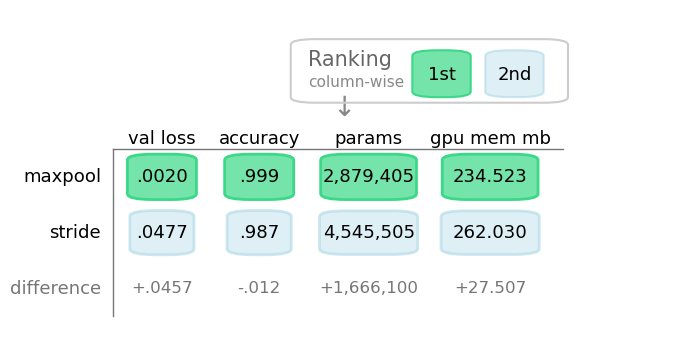

In [5]:
plot_table_task4_metrics(df_abl, f"{RESULTS_DIR}/task4_metric_table.png")

## Results Analysis 
Most state-of-the-art CNNs for object recognition alternate convolutional and pooling layers, followed by a few fully connected layers. Following [(Springenberg et al., 2015)](https://arxiv.org/pdf/1412.6806), let $f$ be a feature map with dimensions width × height × channels. The $p$-norm for downsampling with pooling size $k$ and stride $r$ is a 3D array $s(f)$ defined as:

$$
s_{i,j,u}(f) = \left(\sum_{h=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} \sum_{w=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} \left| f_{g(h,w,i,j,u)} \right|^p \right)^{1/p}, \,\text{with} \quad
g(h,w,i,j,u) = (r \cdot i + h, r \cdot j + w, u)
$$

Setting $p = \infty$ gives max pooling. Otherwise, applying a convolution layer gives:

$$
c_{i,j,o}(f) = \sigma \left( \sum_{h=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} \sum_{w=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} \sum_{u=1} \theta_{h,w,u,o} * f_{h,w,i,j,u,o} \right)
$$

where $\theta$ are learnable weights, $\sigma(\cdot)$ is a nonlinear activation, and $o$ indexes output channels. This shows that pooling can be seen as a feature-wise convolution with $\theta_{h,w,u,o}=1$ and $o=u$, but replacing the activation with the $p$-norm. 

Theoretically, while strided convolution increases the number of learnable parameters, pooling introduces invariance via the $p$-norm, reduces spatial dimensions to cover larger input regions in higher layers, and simplifies optimization by keeping features separate and selecting the most prominent features. However, unlike pooling, strided convolutions have learnable weights, allowing the network to decide which features to preserve or emphasize during downsampling, and gradients propagate through them, potentially capturing more spatial information and feature interactions compared to non-learnable layers. In summary, strided convolutions trade off the simplicity and invariance of pooling for richer, learnable feature extraction and larger effective receptive fields.

By setting `stride=2` and `padding=1` for the Strided variant, and `kernel=2` for the MaxPool-based architecture for comparison, the experiments show **a clear advantage for the MaxPool-based architecture**. Both models achieved high accuracy, but the MaxPool variant reached `99.92%` versus `98.73%` for the Strided Convolution. Validation loss also favors MaxPool (`0.002` vs `0.048`), indicating higher confidence. The MaxPool model is more efficient, using `1.66 million fewer parameters` and approximately `10% less GPU memory`.  While the Strided variant increases representational capacity, it complicates gradient flow, as an additional `1.6M parameters` across four layers must be optimized. For this task - identifying geometric primitives from RGB and LiDAR - MaxPool’s feature-wise invariance and spatial downsampling are better suited. LiDAR data mapped to Cartesian or polar grids contains sharp depth discontinuities (cube edges) and smooth gradients (sphere curvatures), which MaxPool handles efficiently. Overall, the results suggest the MaxPool-based architecture is preferable for multimodal learning in this scenario.

> **Important Caveat.** 
> These conclusions apply only to the current setup. Data augmentations and regularization methods (e.g., dropout) were not used and could affect the performance of the variants. For more complex classification tasks or non-synthetic data, the Strided variant, in a multimodal context and especially with sufficiently large networks, could yield more stable performance when combined with techniques that mitigate gradient vanishing.